In [265]:
import ast
import pandas as pd

In [369]:
def read_txt(file):
    with open(file) as f: 
        txt = f.read() 
    d = ast.literal_eval(txt)
    return d

In [548]:
# TyDi-QA specific features
accuracy_dict = read_txt('Acc_QA.txt')
init_accuracy_dict = read_txt('Init_Acc_QA.txt')
lexical_dict = read_txt('tydiqa_lex.txt')

# General features
syntactical_dict = read_txt('syntactic_sim.txt')
phonological_dict = read_txt('phonological_sim.txt')
morphological_dict = read_txt('morphological_sim.txt')

In [549]:
df_syn = pd.DataFrame.from_dict(syntactical_dict, orient='index').reset_index()
df_syn = df_syn.rename(columns={
    'index' : 'langs',
    0 : 'syn'
})
df_phon = pd.DataFrame.from_dict(phonological_dict, orient='index').reset_index()
df_phon = df_phon.rename(columns={
    'index' : 'langs',
    0 : 'phon'
})
df_morph = pd.DataFrame.from_dict(morphological_dict, orient='index').reset_index()
df_morph = df_morph.rename(columns={
    'index' : 'langs',
    0 : 'morph'
})

df_syn['s'] = df_syn.apply(lambda row: row['langs'][0], axis=1)
df_syn['t'] = df_syn.apply(lambda row: row['langs'][1], axis=1)

df_general = df_syn.merge(df_phon, on='langs', how='inner')
df_general = df_general.merge(df_morph, on='langs', how='inner')

In [550]:
iso_code = {
    'en':'eng',
    'fi':'fin',
    'ar':'ara',
    'bn':'ben',
    'id':'ind',
    'ko':'kor',
    'ru':'rus',
    'sw':'swh',
    'te':'tel'
}

In [551]:
df_init_acc = pd.DataFrame.from_dict(init_accuracy_dict, orient='index').reset_index()
df_init_acc['lang'] = df_init_acc.apply(lambda row: iso_code[row['index']], axis=1)
df_init_acc = df_init_acc.drop(columns = ['exact_match', 'index'])
df_init_acc = df_init_acc.rename(columns={
    'f1':'init_f1_T'
})

df_qa = df_general.merge(df_init_acc, left_on='t', right_on='lang', how='inner')

In [552]:
df_acc = pd.DataFrame.from_dict(accuracy_dict, orient='index').reset_index()
df_acc['langs'] = df_acc.apply(lambda row: (iso_code[row['level_0']], iso_code[row['level_1']]), axis=1)
df_acc = df_acc.drop(columns=['level_0', 'level_1', 'level_2', 'exact_match'])
df_acc = df_acc.rename(columns={
    'f1':'f1_T'
})
df_qa = df_qa.merge(df_acc, on='langs', how='inner')

In [553]:
df_acc_S = df_acc.copy()
df_acc_S['flag'] = df_acc_S.apply(lambda row: 1 if row['langs'][0]==row['langs'][1] else 0, axis=1)
df_acc_S = df_acc_S.loc[df_acc_S['flag']==1]
df_acc_S['lang'] = df_acc_S.apply(lambda row: row['langs'][0], axis=1)
df_acc_S = df_acc_S.drop(columns = ['langs', 'flag'])
df_acc_S = df_acc_S.rename(columns={
    'f1_T' : 'f1_S'
})

df_qa = df_qa.merge(df_acc_S, left_on='s', right_on='lang', how='inner')

In [554]:
df_lex = pd.DataFrame.from_dict(lexical_dict, orient='index').reset_index()
df_lex['langs'] = df_lex.apply(lambda row: (iso_code[row['index'][0]], iso_code[row['index'][1]]), axis=1)
df_lex = df_lex.drop(columns='index')
df_lex = df_lex.rename(columns={
    0 : 'lex'
})
df_lex
df_qa = df_qa.merge(df_lex, on='langs', how='inner')

In [555]:
df_qa['init_f1_T'] = df_qa['init_f1_T']/100
df_qa['f1_S'] = df_qa['f1_S']/100
df_qa['f1_T'] = df_qa['f1_T']/100

In [556]:
df_qa = df_qa[['s','t','syn','phon','morph','lex','init_f1_T', 'f1_S','f1_T']]
df_qa=df_qa.rename(columns={
    'init_f1_T':'LM',
    'f1_S':'S_s',
    'f1_T':'S_t'
})

In [557]:
df_qa.loc[df_qa.s!=df_qa.t].sort_values(['t', 's']).reset_index(drop=True).head(4)

,s,t,syn,phon,morph,lex,LM,S_s,S_t
0,ben,ara,0.296296,0.615385,0.111111,0.343902,0.124259,0.679622,0.333755
1,eng,ara,0.421053,0.600000,0.025641,0.304094,0.124259,0.683939,0.542399
2,fin,ara,0.438596,0.600000,0.076923,0.298701,0.124259,0.764442,0.575941
3,ind,ara,0.470588,0.600000,0.025641,0.309252,0.124259,0.804405,0.648013


In [558]:
df_qa.loc[df_qa.s!=df_qa.t].sort_values(['t', 's']).reset_index(drop=True).to_csv('QA_Regression.csv')

In [559]:
df_qa.loc[df_qa['s']=='ara']

,s,t,syn,phon,morph,lex,LM,S_s,S_t
0,ara,ara,1.000000,1.000000,1.000000,0.000000,0.124259,0.779937,0.779937
1,ara,ben,0.296296,0.615385,0.111111,0.343902,0.024496,0.779937,0.534127
2,ara,eng,0.421053,0.600000,0.025641,0.304094,0.089544,0.779937,0.647949
3,ara,fin,0.438596,0.600000,0.076923,0.298701,0.107589,0.779937,0.616743
4,ara,ind,0.470588,0.600000,0.025641,0.309252,0.101422,0.779937,0.690251
5,ara,kor,0.271186,0.400000,0.057143,0.341142,0.046024,0.779937,0.525410
6,ara,rus,0.481481,0.692308,0.052632,0.293203,0.074254,0.779937,0.639453
7,ara,swh,0.558140,0.500000,0.027027,0.353414,0.077539,0.779937,0.527111
8,ara,tel,0.268293,0.615385,0.200000,0.350134,0.048394,0.779937,0.264195


In [569]:
qa_st_corr = {}
for i in ['S_s', 'syn', 'phon', 'morph', 'lex', 'LM']:
    qa_st_corr[i] = df_qa['S_t'].corr(df_qa[i])

qa_st_corr

{'S_s': 0.3265259930628872,
 'syn': 0.5986945033090747,
 'phon': 0.458320936677176,
 'morph': 0.5634904288727139,
 'lex': -0.7012788343964714,
 'LM': 0.2358636055371056}

In [485]:
accuracy_dict_ner = read_txt('NER_output.txt')
init_accuracy_dict_ner = read_txt('NER_not_tuned.txt')
lexical_dict_ner = read_txt('lexical_sims.txt')

for i in iso_code.keys():
    lexical_dict_ner[(i,i)] = 0.0

for i in lexical_dict_ner.keys():
    lexical_dict_ner[i] = lexical_dict_ner[i]/100

init_accuracy_dict_ner_2 = {}
for i in init_accuracy_dict_ner.keys():
    if i[0] == i[1]:
        init_accuracy_dict_ner_2[i[0]] = init_accuracy_dict_ner[i]

In [486]:
df_init_acc_ner = pd.DataFrame.from_dict(init_accuracy_dict_ner_2, orient='index').reset_index()
df_init_acc_ner['lang'] = df_init_acc_ner.apply(lambda row: iso_code[row['index']], axis=1)
df_init_acc_ner = df_init_acc_ner.drop(columns = ['index'])
df_init_acc_ner = df_init_acc_ner.rename(columns={
    0:'init_f1_T'
})

df_qa_ner = df_general.merge(df_init_acc_ner, left_on='t', right_on='lang', how='inner')

In [487]:
df_acc_ner = pd.DataFrame.from_dict(accuracy_dict_ner, orient='index').reset_index()
df_acc_ner['langs'] = df_acc_ner.apply(lambda row: (iso_code[row['index'][0]], iso_code[row['index'][1]]), axis=1)
df_acc_ner = df_acc_ner.drop(columns=['index'])
df_acc_ner = df_acc_ner.rename(columns={
    0:'f1_T'
})

df_qa_ner = df_qa_ner.merge(df_acc_ner, on='langs', how='inner')

In [488]:
df_acc_S_ner = df_acc_ner.copy()
df_acc_S_ner['flag'] = df_acc_S_ner.apply(lambda row: 1 if row['langs'][0]==row['langs'][1] else 0, axis=1)
df_acc_S_ner = df_acc_S_ner.loc[df_acc_S_ner['flag']==1]
df_acc_S_ner['lang'] = df_acc_S_ner.apply(lambda row: row['langs'][0], axis=1)
df_acc_S_ner = df_acc_S_ner.drop(columns = ['langs', 'flag'])
df_acc_S_ner = df_acc_S_ner.rename(columns={
    'f1_T' : 'f1_S'
})

df_qa_ner = df_qa_ner.merge(df_acc_S_ner, left_on='s', right_on='lang', how='inner')

In [489]:
df_lex_ner = pd.DataFrame.from_dict(lexical_dict_ner, orient='index').reset_index()
df_lex_ner['langs'] = df_lex_ner.apply(lambda row: (iso_code[row['index'][0]], iso_code[row['index'][1]]), axis=1)
df_lex_ner = df_lex_ner.drop(columns='index')
df_lex_ner = df_lex_ner.rename(columns={
    0 : 'lex'
})
df_lex
df_qa_ner = df_qa_ner.merge(df_lex_ner, on='langs', how='inner')

In [480]:
# df_qa_ner['init_f1_T'] = df_qa_ner['init_f1_T']*100
# df_qa_ner['f1_S'] = df_qa_ner['f1_S']*100
# df_qa_ner['f1_T'] = df_qa_ner['f1_T']*100


In [490]:
df_qa_ner = df_qa_ner[['s','t','syn','phon','morph','lex','init_f1_T', 'f1_S','f1_T']]

In [494]:
df_qa_ner=df_qa_ner.rename(columns={
    'init_f1_T':'LM',
    'f1_S':'S_s',
    'f1_T':'S_t'
})

In [491]:
df_qa_ner.loc[df_qa_ner.s!=df_qa_ner.t].to_csv('NER_Regression.csv')

In [484]:
df_qa_ner.loc[df_qa_ner.s!=df_qa_ner.t]

,s,t,syn,phon,morph,lex,LM,S_s,S_t
1,ara,ben,0.296296,0.615385,0.111111,0.013625,0.094703,0.015072,0.062600
2,ara,eng,0.421053,0.600000,0.025641,0.000000,0.105965,0.015072,0.558210
3,ara,fin,0.438596,0.600000,0.076923,0.000000,0.113299,0.015072,0.118732
4,ara,ind,0.470588,0.600000,0.025641,0.010320,0.078045,0.015072,0.570833
5,ara,kor,0.271186,0.400000,0.057143,0.000000,0.248669,0.015072,0.749041
...,...,...,...,...,...,...,...,...,...
75,tel,fin,0.466667,0.800000,0.205128,0.000000,0.113299,0.042450,0.066588
76,tel,ind,0.212121,0.888889,0.128205,0.014511,0.078045,0.042450,0.451020
77,tel,kor,0.720000,0.666667,0.171429,0.000000,0.248669,0.042450,0.672914
78,tel,rus,0.354839,0.888889,0.102564,0.000000,0.109691,0.042450,0.050243


In [495]:
df_qa_ner.loc[df_qa_ner.s!=df_qa_ner.t].sort_values(['t', 's']).reset_index(drop=True).head(4)

,s,t,syn,phon,morph,lex,LM,S_s,S_t
0,ben,ara,0.296296,0.615385,0.111111,0.013625,0.110902,0.241917,0.111306
1,eng,ara,0.421053,0.600000,0.025641,0.000000,0.110902,0.620021,0.121354
2,fin,ara,0.438596,0.600000,0.076923,0.000000,0.110902,0.667381,0.399154
3,ind,ara,0.470588,0.600000,0.025641,0.010320,0.110902,0.113821,0.507614


In [560]:
p = pd.read_csv('QA_Pred.csv')
c = p.columns[0]
x = c.split(' ')
x2 = x[2:]
x2
x3 = []
for i in x2:
    x3.append(float(i))

p.rename(columns={c:'col'}, inplace=True)

x4 = p.col[0].split(' ')[1:]
x4
for i in x4:
    x3.append(float(i))

x5 = p.col[1].split(' ')[1:]
x5
for i in x5:
    x3.append(float(i))

x6 = p.col[2].split(' ')[1:]
x6
for i in x6:
    x3.append(float(i))

In [562]:
df_qa_pred = df_qa.loc[df_qa.s!=df_qa.t].sort_values(['t', 's']).reset_index(drop=True)

In [564]:
df_qa_pred['Pred_S_t'] = x3
df_qa_pred

,s,t,syn,phon,morph,lex,LM,S_s,S_t,Pred_S_t
0,ben,ara,0.296296,0.615385,0.111111,0.343902,0.124259,0.679622,0.333755,0.443524
1,eng,ara,0.421053,0.600000,0.025641,0.304094,0.124259,0.683939,0.542399,0.525789
2,fin,ara,0.438596,0.600000,0.076923,0.298701,0.124259,0.764442,0.575941,0.569921
3,ind,ara,0.470588,0.600000,0.025641,0.309252,0.124259,0.804405,0.648013,0.574619
4,kor,ara,0.271186,0.400000,0.057143,0.341142,0.124259,0.585906,0.362144,0.407828
...,...,...,...,...,...,...,...,...,...,...
67,fin,tel,0.466667,0.800000,0.205128,0.318502,0.048394,0.764442,0.345627,0.487566
68,ind,tel,0.212121,0.888889,0.128205,0.312407,0.048394,0.804405,0.358314,0.519722
69,kor,tel,0.720000,0.666667,0.171429,0.335103,0.048394,0.585906,0.347936,0.379496
70,rus,tel,0.354839,0.888889,0.102564,0.324472,0.048394,0.762295,0.422042,0.482323


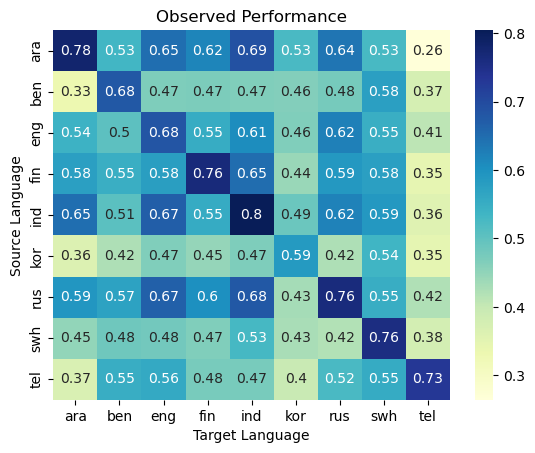

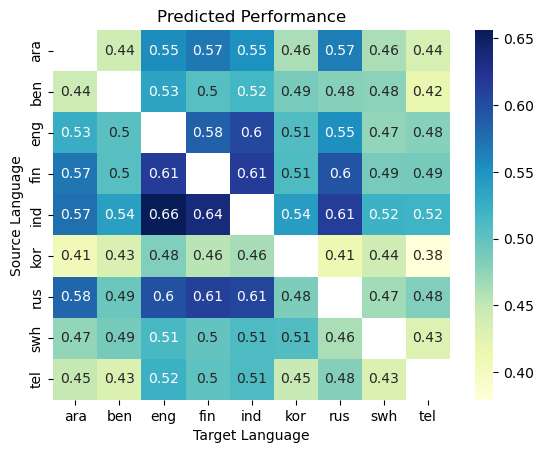

In [573]:
import seaborn as sns
import matplotlib.pyplot as plt

df_pivot = df_qa.pivot(index='s', columns='t', values='S_t')
ax = sns.heatmap(df_pivot, cmap="YlGnBu", annot=True)
ax.set_title("Observed Performance")
ax.set(xlabel='Target Language', ylabel='Source Language')
plt.show()

df_pivot2 = df_qa_pred.pivot(index='s', columns='t', values='Pred_S_t')
ax = sns.heatmap(df_pivot2, cmap="YlGnBu", annot=True)
ax.set_title("Predicted Performance")
ax.set(xlabel='Target Language', ylabel='Source Language')
plt.show()